In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LinearRegression
from torchvision.models import ResNet18_Weights

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

C:\Users\Deвайс\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Загрузка данных
train_data = pd.read_csv('/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/to_upload/train_dataset.csv')

crowd_annotations = pd.read_csv('/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/to_upload/CrowdAnnotations.tsv', sep='\t',
                                 header=None, names=['image_file', 'query_id', 'score', 'yes', 'no'])

expert_annotations = pd.read_csv('/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/to_upload/ExpertAnnotations.tsv', sep='\t',
                                  header=None, names=['image_file', 'query_id', 'ex_1', 'ex_2', 'ex_3'])

test_queries = pd.read_csv('/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/to_upload/test_queries.csv',
                            sep='|', header=None, names=['query_id', 'query_text', 'image'], skiprows=1)

In [3]:
# Просмотр данных
display(train_data.head())

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [4]:
display(crowd_annotations.head(10))

,image_file,query_id,score,yes,no
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3


In [5]:
display(expert_annotations.head())

,image_file,query_id,ex_1,ex_2,ex_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [6]:
display(test_queries.head())

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [8]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_file  47830 non-null  object 
 1   query_id    47830 non-null  object 
 2   score       47830 non-null  float64
 3   yes         47830 non-null  int64  
 4   no          47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [9]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_file  5822 non-null   object
 1   query_id    5822 non-null   object
 2   ex_1        5822 non-null   int64 
 3   ex_2        5822 non-null   int64 
 4   ex_3        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [10]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


1. Очистка текста
Сначала мы очистим текст в колонке query_text в датасете train_data:

Приведение к нижнему регистру.
Удаление небуквенных символов.
Удаление лишних пробелов.

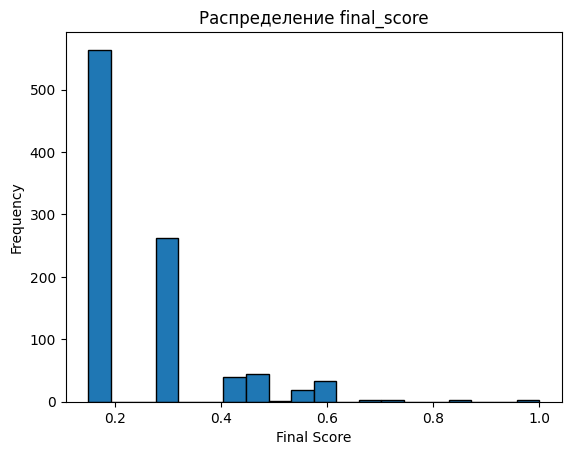

In [12]:
# 1. Обработка данных экспертных оценок
def aggregate_expert_scores(row):
    scores = [row['ex_1'], row['ex_2'], row['ex_3']]
    if len(set(scores)) == 3:  # Если все три оценки разные
        return np.mean(scores)  # Используем среднее
    return max(set(scores), key=scores.count)  # Голосование большинства

# Применяем функцию для агрегирования оценок
expert_annotations['aggregated_score'] = expert_annotations.apply(aggregate_expert_scores, axis=1)

# Удаляем пары с конфликтующими оценками
expert_annotations = expert_annotations.dropna(subset=['aggregated_score'])

# Нормализуем итоговые оценки в диапазон [0, 1]
expert_annotations['aggregated_score'] = expert_annotations['aggregated_score'] / 4

# 2. Обработка данных краудсорсинговых оценок
# Нормализация краудсорсинговой оценки
crowd_annotations['crowd_score'] = crowd_annotations['score'] / crowd_annotations['score'].max()

# Удаление дубликатов
expert_annotations = expert_annotations.drop_duplicates(subset=['query_id'])
crowd_annotations = crowd_annotations.drop_duplicates(subset=['query_id'])

# 3. Объединение данных
# Используем inner join для пересечения данных (можно заменить на outer или left при необходимости)
merged_scores = pd.merge(
    expert_annotations[['query_id', 'aggregated_score']],
    crowd_annotations[['query_id', 'crowd_score']],
    on='query_id',
    how='inner'
)

# Итоговая целевая переменная с учетом коэффициентов
merged_scores['final_score'] = (
    0.6 * merged_scores['aggregated_score'] +
    0.4 * merged_scores['crowd_score']
)

# Проверяем распределение final_score
import matplotlib.pyplot as plt
plt.hist(merged_scores['final_score'], bins=20, edgecolor='black')
plt.title('Распределение final_score')
plt.xlabel('Final Score')
plt.ylabel('Frequency')
plt.show()


In [13]:
import re

# Функция для очистки текста
def preprocess_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Удаление небуквенных символов
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов
    return text

# Применяем очистку к колонке query_text
train_data['clean_text'] = train_data['query_text'].apply(preprocess_text)

In [14]:
# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для токенизации и лемматизации
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)  # Токенизация
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Лемматизация
    return lemmatized_tokens

# Применяем токенизацию и лемматизацию к очищенному тексту
train_data['tokens'] = train_data['clean_text'].apply(tokenize_and_lemmatize)

In [15]:
from nltk.probability import FreqDist
import pandas as pd

# Собираем все токены из датасета
tokens_list = [token for tokens in train_data['tokens'] for token in tokens]

# Частотный анализ
freq_dist = FreqDist(tokens_list)

# Создание DataFrame с частотностью
freq_df = pd.DataFrame.from_dict(freq_dist, orient='index', columns=['freq'])
freq_df = freq_df.sort_values(by='freq', ascending=False)

# Просмотр 50 наиболее частых слов
print(freq_df.index.tolist())

['a', 'in', 'the', 'on', 'dog', 'is', 'and', 'with', 'man', 'of', 'two', 'white', 'woman', 'boy', 'girl', 'black', 'to', 'at', 'wearing', 'water', 'an', 'young', 'people', 'red', 'are', 'his', 'child', 'blue', 'while', 'through', 'little', 'down', 'brown', 'running', 'over', 'person', 'shirt', 'jump', 'run', 'playing', 'standing', 'ball', 'grass', 'front', 'beach', 'sitting', 'small', 'field', 'stand', 'snow', 'player', 'rock', 'riding', 'up', 'next', 'street', 'play', 'it', 'smiling', 'jumping', 'look', 'men', 'into', 'green', 'three', 'air', 'mouth', 'bike', 'one', 'walk', 'group', 'camera', 'off', 'mountain', 'dirt', 'by', 'pool', 'building', 'large', 'her', 'near', 'yellow', 'walking', 'crowd', 'tree', 'holding', 'top', 'hat', 'watch', 'ocean', 'jacket', 'swing', 'another', 'basketball', 'pink', 'background', 'river', 'from', 'football', 'soccer', 'kid', 'sits', 'along', 'city', 'uniform', 'path', 'race', 'being', 'beside', 'around', 'hill', 'orange', 'sand', 'outside', 'dressed', 

In [16]:
# Список запрещённых слов, связанных с детьми
child_related_keywords = ['child', 'baby', 'kid', 'toddler', 'teenager']

In [17]:
# Функция для проверки наличия слов, связанных с детьми
def contains_child_keywords(tokens, keywords=child_related_keywords):
    return any(token in keywords for token in tokens)

# Помечаем записи, связанные с детьми
train_data['child_related'] = train_data['tokens'].apply(contains_child_keywords)

# Список изображений для исключения
excluded_images = train_data[train_data['child_related']]['image'].unique()

# Фильтрация данных
filtered_train_data = train_data[~train_data['image'].isin(excluded_images)].copy()

# Итоговый вывод
print(f"Исключено {len(train_data) - len(filtered_train_data)} записей, связанных с детьми.")

Исключено 2399 записей, связанных с детьми.


In [18]:
filtered_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3423 entries, 14 to 5821
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          3423 non-null   object
 1   query_id       3423 non-null   object
 2   query_text     3423 non-null   object
 3   clean_text     3423 non-null   object
 4   tokens         3423 non-null   object
 5   child_related  3423 non-null   bool  
dtypes: bool(1), object(5)
memory usage: 163.8+ KB


In [19]:
from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertModel
import torch

# Проверяем доступность устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загружаем токенизатор и модель BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_emb_txt = BertModel.from_pretrained('bert-base-uncased').to(device)

# Функция для токенизации и создания эмбеддингов текста
def get_text_embeddings(texts, batch_size=32):
    tokenized = [tokenizer.encode(text, max_length=512, truncation=True, add_special_tokens=True) for text in texts]
    padded = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in tokenized], batch_first=True)
    attention_mask = (padded > 0).to(device)
    
    embeddings = []
    for i in tqdm(range(0, len(padded), batch_size)):
        batch = padded[i:i + batch_size].to(device)
        attention_mask_batch = attention_mask[i:i + batch_size]
        
        with torch.no_grad():
            outputs = model_emb_txt(batch, attention_mask=attention_mask_batch)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Получаем эмбеддинги текстов
train_data['text_embeddings'] = list(get_text_embeddings(train_data['query_text']))


  0%|          | 0/182 [00:00<?, ?it/s]

In [20]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image
import os
from tqdm.notebook import tqdm
import numpy as np
import torch

# Устанавливаем путь к папке с изображениями
IMAGE_DIR = '/Users/chajartem/Yandex_Praktikum_DS2024_datasetst/to_upload/train_images'

# Загрузка модели ResNet
resnet = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Убираем последний слой
resnet.eval()

# Преобразование изображений
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Функция для векторизации изображений
def get_image_embeddings(image_list, image_dir, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(image_list), batch_size)):
        batch_images = []
        for img_name in image_list[i:i + batch_size]:
            img_path = os.path.join(image_dir, img_name)
            try:
                image = Image.open(img_path).convert('RGB')
                image_tensor = preprocess(image).unsqueeze(0).to(device)
                batch_images.append(image_tensor)
            except Exception as e:
                print(f"Ошибка при обработке {img_name}: {e}")
        
        if batch_images:
            batch_images = torch.cat(batch_images)
            with torch.no_grad():
                batch_embeddings = resnet(batch_images).flatten(start_dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Получение списка уникальных изображений
unique_images = train_data['image'].unique()

# Векторизация изображений
image_vectors = get_image_embeddings(unique_images, IMAGE_DIR)

# Сопоставляем изображения и их векторы
image_embeddings = dict(zip(unique_images, image_vectors))

# Добавляем вектор изображения в train_data
train_data['image_vector'] = train_data['image'].map(image_embeddings)

  0%|          | 0/63 [00:00<?, ?it/s]

In [21]:
# Объединение текстовых и визуальных эмбеддингов
train_data['concatenated_vector'] = train_data.apply(
    lambda row: np.concatenate([row['text_embeddings'], row['image_vector']]),
    axis=1
)

# Проверяем размеры объединённых векторов
print(f"Размер текстового эмбеддинга: {len(train_data.iloc[0]['text_embeddings'])}")
print(f"Размер визуального эмбеддинга: {len(train_data.iloc[0]['image_vector'])}")
print(f"Размер объединённого вектора: {len(train_data.iloc[0]['concatenated_vector'])}")


Размер текстового эмбеддинга: 768
Размер визуального эмбеддинга: 512
Размер объединённого вектора: 1280


In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image                5822 non-null   object
 1   query_id             5822 non-null   object
 2   query_text           5822 non-null   object
 3   clean_text           5822 non-null   object
 4   tokens               5822 non-null   object
 5   child_related        5822 non-null   bool  
 6   text_embeddings      5822 non-null   object
 7   image_vector         5822 non-null   object
 8   concatenated_vector  5822 non-null   object
dtypes: bool(1), object(8)
memory usage: 369.7+ KB


In [23]:
# Объединяем оценки с векторами изображений и текстов

# Объединяем merged_scores с train_data
train_with_scores = pd.merge(
    train_data,
    merged_scores[['query_id', 'final_score']],
    on='query_id',
    how='inner'
)

# Объединяем текстовые и визуальные эмбеддинги в один вектор
train_with_scores['concatenated_vector'] = train_with_scores.apply(
    lambda row: np.concatenate([row['text_embeddings'], row['image_vector']]),
    axis=1
)

# Формируем итоговый датасет
final_dataset = train_with_scores[['image', 'concatenated_vector', 'final_score']]

# Проверяем итоговую структуру
print(final_dataset.head())

                       image  \
0  1056338697_4f7d7ce270.jpg   
1  1262583859_653f1469a9.jpg   
2  2447284966_d6bbdb4b6e.jpg   
3  2549968784_39bfbe44f9.jpg   
4  2621415349_ef1a7e73be.jpg   

                                 concatenated_vector  final_score  
0  [-0.047877204, 0.051415317, -0.27281323, -0.07...         0.15  
1  [-0.047877204, 0.051415317, -0.27281323, -0.07...         0.15  
2  [-0.047877204, 0.051415317, -0.27281323, -0.07...         0.15  
3  [-0.047877204, 0.051415317, -0.27281323, -0.07...         0.15  
4  [-0.047877204, 0.051415317, -0.27281323, -0.07...         0.15  


In [24]:
print(f"Размер train_data: {train_data.shape}")
print(f"Размер merged_scores: {merged_scores.shape}")

Размер train_data: (5822, 9)
Размер merged_scores: (977, 4)


In [25]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

# Разделение данных на тренировочную и тестовую выборки с учётом группировки по изображениям
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_indices, test_indices = next(gss.split(final_dataset, 
                                             groups=final_dataset['image']))


In [26]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                5822 non-null   object 
 1   concatenated_vector  5822 non-null   object 
 2   final_score          5822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 136.6+ KB


In [27]:
train_df = final_dataset.iloc[train_indices]
test_df = final_dataset.iloc[test_indices]

# Преобразуем данные в массивы
X_train = np.stack(train_df['concatenated_vector'])
X_test = np.stack(test_df['concatenated_vector'])
y_train = train_df['final_score'].values
y_test = test_df['final_score'].values

# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Проверим размерности данных
print(f"Размер X_train: {X_train_scaled.shape}, Размер y_train: {y_train.shape}")
print(f"Размер X_test: {X_test_scaled.shape}, Размер y_test: {y_test.shape}")

Размер X_train: (4671, 1280), Размер y_train: (4671,)
Размер X_test: (1151, 1280), Размер y_test: (1151,)


In [28]:
# Проверка на пропуски
print(final_dataset.isnull().sum())

# Проверка типов данных
print(final_dataset.dtypes)

# Проверка длины векторов
print(final_dataset['concatenated_vector'].apply(len).describe())


image                  0
concatenated_vector    0
final_score            0
dtype: int64
image                   object
concatenated_vector     object
final_score            float64
dtype: object
count    5822.0
mean     1280.0
std         0.0
min      1280.0
25%      1280.0
50%      1280.0
75%      1280.0
max      1280.0
Name: concatenated_vector, dtype: float64


In [29]:
print(f"Train indices: {train_indices[:5]}")
print(f"Test indices: {test_indices[:5]}")

# Проверим пересечение между train и test
common_images = set(train_df['image']).intersection(set(test_df['image']))
print(f"Количество общих изображений в train и test: {len(common_images)}")


Train indices: [0 1 2 3 4]
Test indices: [ 7 14 18 19 35]
Количество общих изображений в train и test: 0


In [30]:
print(f"Тип X_train: {type(X_train)}, Размер: {X_train.shape}")
print(f"Тип X_test: {type(X_test)}, Размер: {X_test.shape}")

Тип X_train: <class 'numpy.ndarray'>, Размер: (4671, 1280)
Тип X_test: <class 'numpy.ndarray'>, Размер: (1151, 1280)


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Создаем и обучаем модель
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Предсказания
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Оценка модели
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Train MSE: 0.0021
Test MSE: 0.0090


In [32]:
import torch.nn as nn
import torch.optim as optim

# Определяем модель
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Инициализация модели, оптимизатора и функции потерь
input_dim = X_train_scaled.shape[1]
model = MLPModel(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# Обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Вывод метрики каждые 10 эпох
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test_tensor)
            test_loss = criterion(test_predictions, y_test_tensor).item()
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")


Epoch 10/50, Train Loss: 0.0204, Test Loss: 0.0196
Epoch 20/50, Train Loss: 0.0108, Test Loss: 0.0132
Epoch 30/50, Train Loss: 0.0055, Test Loss: 0.0107
Epoch 40/50, Train Loss: 0.0030, Test Loss: 0.0090
Epoch 50/50, Train Loss: 0.0016, Test Loss: 0.0080


In [33]:
from sklearn.metrics import r2_score

test_predictions_np = test_predictions.cpu().numpy()
r2 = r2_score(y_test, test_predictions_np)
print(f"R^2 на тестовой выборке: {r2:.4f}")

R^2 на тестовой выборке: 0.5749


In [34]:
import optuna

# Функция для обучения модели с заданными гиперпараметрами
def objective(trial):
    # Гиперпараметры, которые будет подбирать Optuna
    hidden_dim1 = trial.suggest_int("hidden_dim1", 128, 1024, step=128)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 64, 512, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    # Определяем модель с текущими гиперпараметрами
    class MLPModel(nn.Module):
        def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout_rate):
            super(MLPModel, self).__init__()
            self.network = nn.Sequential(
                nn.Linear(input_dim, hidden_dim1),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dim1, hidden_dim2),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dim2, 1)
            )
        
        def forward(self, x):
            return self.network(x)

    # Инициализация модели, функции потерь и оптимизатора
    input_dim = X_train_scaled.shape[1]
    model = MLPModel(input_dim, hidden_dim1, hidden_dim2, dropout_rate).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Обучение модели
    num_epochs = 20  # Можно увеличить для более точной оптимизации
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Оценка модели на тестовой выборке
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor).item()

    return test_loss  # Возвращаем метрику для минимизации

# Создаём объект для поиска
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Количество итераций

# Лучшие гиперпараметры
print("Best hyperparameters:", study.best_params)
print("Best test loss:", study.best_value)


[I 2024-12-10 15:27:52,896] A new study created in memory with name: no-name-c24bd083-3947-4aeb-9307-cab377ed8974
/var/folders/w6/dr6wrr0962d5n5ws0rghxq640000gn/T/ipykernel_38073/1671758717.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2024-12-10 15:27:54,118] Trial 0 finished with value: 0.035784464329481125 and parameters: {'hidden_dim1': 384, 'hidden_dim2': 512, 'dropout_rate': 0.1, 'lr': 0.005538052002208197}. Best is trial 0 with value: 0.035784464329481125.
[I 2024-12-10 15:27:55,450] Trial 1 finished with value: 0.016780423000454903 and parameters: {'hidden_dim1': 640, 'hidden_dim2': 256, 'dropout_rate': 0.5, 'lr': 0.00011400730947327706}. Best is trial 1 with value: 0.016780423000454903.
[I 2024-12-10 15:27:56,270] Trial 2 finished with value: 0.016435960307717323

Best hyperparameters: {'hidden_dim1': 640, 'hidden_dim2': 64, 'dropout_rate': 0.1, 'lr': 0.0003760738656891948}
Best test loss: 0.009030180983245373


In [35]:
# Финальная модель с лучшими гиперпараметрами
final_model = MLPModel(
    input_dim=X_train_scaled.shape[1],
    hidden_dim1=study.best_params["hidden_dim1"],
    hidden_dim2=study.best_params["hidden_dim2"],
    dropout_rate=study.best_params["dropout_rate"]
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=study.best_params["lr"])

# Обучение финальной модели
final_model.train()
for epoch in range(30):  # Увеличиваем число эпох для финальной модели
    optimizer.zero_grad()
    predictions = final_model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Переводим модель в режим оценки
final_model.eval()

TypeError: MLPModel.__init__() got an unexpected keyword argument 'hidden_dim1'

In [ ]:
# Тестовые запросы
test_queries = [
    "A hiker poses in front of a mountain with clouds.",
    "A dog running in a park.",
    "A beautiful sunset over the ocean.",
    "A child playing with a toy car.",
    "A couple walking on a bridge."
]

# Вывод результатов
for query in test_queries:
    print(f"Запрос: {query}")
    result = find_most_relevant_image(query, final_model, image_embeddings, child_related_keywords)
    if isinstance(result, str):
        print(result)  # Дисклеймер
    else:
        best_image, score = result
        print(f"Наиболее релевантное изображение: {best_image} (оценка: {score:.4f})")
        image_path = os.path.join(IMAGE_DIR, best_image)
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(f"Релевантное изображение (оценка: {score:.4f})")
        plt.axis('off')
        plt.show()
